In [1]:
from moleculib.protein.dataset import MonomerDataset
from moleculib.protein.transform import (
    ProteinCrop,
    DescribeChemistry,
)

from collections import defaultdict
from moleculib.protein.alphabet import all_residues
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

data_path = '/mas/projects/molecularmachines/db/PDB'
min_seq_len = 16
max_seq_len = sequence_length = 512
dataset = MonomerDataset(
    base_path=data_path,
    attrs="all",
    max_resolution=1.7,
    min_sequence_length=min_seq_len,
    max_sequence_length=max_seq_len,
    frac=1.0,
    transform=[
        ProteinCrop(crop_size=sequence_length),
        DescribeChemistry(),
        # builds(TokenizeSequenceBoundaries),
        # builds(ProteinPad, pad_size=sequence_length, random_position=True),
        # builds(MaybeMirror, hand="right"),
        # builds(CastToBFloat),
    ],
)

In [52]:
counter = 0
num_data = 100

# remove peptide bonds
num_bonds = 18

residue_sum_bond_len = defaultdict(lambda: np.zeros((num_bonds, ), dtype=np.float64))
residue_sum_bond_mask = defaultdict(lambda: np.zeros((num_bonds, ), dtype=np.int32))

peptide_sum_bond_len = np.zeros(1, dtype=np.float64)
peptide_sum_bond_mask = np.zeros(1, dtype=np.int32)

for datum in dataset:
    all_atoms = rearrange(datum.atom_coord, 'r a c -> (r a) c')
    all_bonds = rearrange(datum.bonds_list, 'r b i -> (r b) i')

    v, u = all_bonds.T
    bonds_len = np.sqrt(np.square(all_atoms[v] - all_atoms[u]).sum(-1))
    bonds_len_ = rearrange(bonds_len, '(r b) -> r b', r=len(datum.residue_token))

    peptide_sum_bond_len += bonds_len_[..., -1].sum(-1)
    peptide_sum_bond_mask += datum.bonds_mask[..., -1].sum(-1)

    res_bond_len = bonds_len_[..., :-1]
    res_bond_mask = datum.bonds_mask[..., :-1]
    for token, bonds, mask in zip(datum.residue_token, res_bond_len, res_bond_mask):
        if token == 0: continue
        token = all_residues[token]

        residue_sum_bond_len[token] += bonds * mask.astype(np.float64)
        residue_sum_bond_mask[token] += mask    

    counter += 1
    if counter == num_data: break

avg_bonds = {}
for token in residue_sum_bond_len.keys():
    avg_bonds_ = residue_sum_bond_len[token] / residue_sum_bond_mask[token]
    avg_bonds_ = avg_bonds_[~np.isnan(avg_bonds_)]
    avg_bonds[token] = avg_bonds_

/tmp/ipykernel_1337295/2594562017.py:41: RuntimeWarning: invalid value encountered in divide
  avg_bonds_ = residue_sum_bond_len[token] / residue_sum_bond_mask[token]


In [33]:
len(avg_bonds.keys())


21

In [55]:
peptide_sum_bond_len / peptide_sum_bond_mask

array([1.35753979])

In [61]:
from moleculib.protein.alphabet import sidechain_chemistry_per_residue

lines = []
for token, props in sidechain_chemistry_per_residue.items():
    lines += [f'{token}=dict(']
    for key, prop in props.items():
        if key == 'bonds':
            lines += [f'    {key}={prop[3:]},']
        else:
            lines += [f'    {key}={prop},']
    lines += [f'    bond_lens=[{",".join([f"{f:.2f}" for f in avg_bonds[token][6:]])}],']
    lines += ['),']

# for line in lines:
#     print(line)

with open('sidechain_chemistry_per_residue.txt', 'w') as f:
    f.write('\n'.join(lines))

In [63]:
stack = [] 
for token, bonds in avg_bonds.items():
    stack.append(avg_bonds[token][:3])

In [69]:
stack.mean(-2)

array([1.46097941, 1.52393017, 1.23405663])

In [48]:
residue_sum_bond_len
token = all_residues[token]

TypeError: list indices must be integers or slices, not str

In [97]:
peptide_lens.shape

(95,)

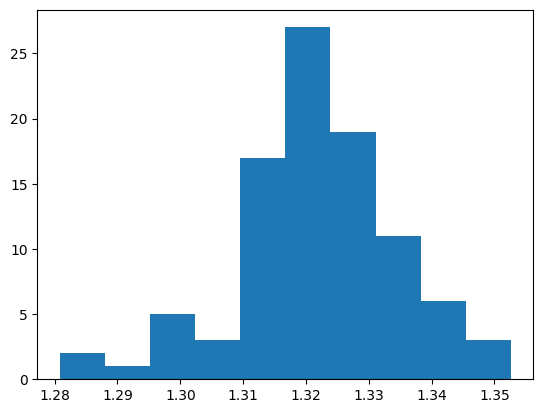

In [86]:
plt.hist(peptide_lens[peptide_mask], bins=10)
plt.show()

In [5]:
bonds_len_.shape

(240, 19)

PHE [1.46012098 1.52338733 1.23111908 1.46012098 1.52338733 1.23111908
 1.53180338 1.50206551 1.384906   1.38544074 1.38186876 1.38103526
 1.38784495 1.38632108 0.         0.         0.         0.        ]
ASP [1.46004581 1.52665993 1.23175658 1.46004581 1.52665993 1.23175658
 1.53213728 1.51939462 1.24939287 1.24979074 0.         0.
 0.         0.         0.         0.         0.         0.        ]
PRO [1.46576054 1.5205094  1.2350703  1.46576054 1.5205094  1.2350703
 1.53547429 1.4900337  1.50326068 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
ALA [1.45815847 1.52526518 1.23433396 1.45815847 1.52526518 1.23433396
 1.52681451 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
GLU [1.45766406 1.52489218 1.23270313 1.45766406 1.52489218 1.23270313
 1.52984242 1.51788303 1.51775431 1.24935823 1.24791914 0.
 0.         0.         0.         0.         0.         0.        ]
LYS

/tmp/ipykernel_1334596/77185035.py:28: RuntimeWarning: invalid value encountered in divide
  avg_bonds = residue_sum_bond_len[token] / residue_sum_bond_mask[token]


array([1.41952744, 1.41952744, 1.41952744, 1.41952744, 1.41952744,
       1.41952744, 1.41952744, 1.41952744, 1.41952744, 1.41952744,
       1.41952744, 1.41952744, 1.41952744, 1.41952744, 1.41952744,
       1.41952744, 1.41952744, 1.41952744, 1.41952744])